In [569]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib
from matplotlib import pyplot as plt

### import and clean data

In [94]:
col_dict = {
    "Kikkel volt interakciód? (Itt ténylegesen megszámolod hogy kikkel interaktáltál)": "Interakciók",
    "Neved": "Név",
    "Nem (1-férfi,0-nő)": "Nem",
    "Beleegyezem, hogy további adataimat az adatbázis készítői átmásolják korábbi lekérdezésekből? (*lásd: szint, szobaszám, nem, szak)": "GDPR",
    "A lekérdezéstől számított egy héten belül laktál a kommunában? (KGY előtt)": "Kommuna",
    "A kérdőív kitöltését megelőző egy héten (KGY előtt) otthon, a családi bázison tartózkodtál?": "Otthon lakás",
    "Hány kollégistával interaktáltál a kérdőív kitöltése előtti egy hétben (KGY előtti)? (csak úgy érzésre, kicsit gondolkozol és egy magadnak meggyőző szám)": "Kontaktok becsült száma",
    "Mennyire volt a koronavírus a központi téma?": "Korona-téma",
    "Mennyit beszélgettetek a koliról?": "Koli-téma",
    "Beszéltetek arról, ki hogyan érzi magát? (lásd: megkérdezted, hogy van)": "Hogylét-téma",
    "Milyen eszközön / platformon interaktáltatok?": "Platform",
}

In [332]:
data = pd.read_excel("poll.xlsx").pipe(
    lambda df: df.drop(
        [
            "Időbélyeg",
            "Mi volt a fő kommunikációs forma?",
            "Darab",
            "Megegyezik",
            "Különbség",
            "Arány",
            "Kikkel volt interakciód? (Itt ténylegesen megszámolod hogy kikkel interaktáltál).1",
        ]
        + [c for c in df.columns if "Unnamed" in c],
        axis=1,
    ).rename(columns=col_dict,)
).fillna("")

In [333]:
data = data.drop("Interakciók", axis=1).merge(
    data["Interakciók"]
    .apply(lambda l: pd.Series(l.split(", ")))
    .pipe(lambda df: df.rename(columns={c: "Kontakt_{}".format(c) for c in df.columns}))
    .fillna(""),
    how="outer",
    left_index=True,
    right_index=True,
)

In [334]:
names = (
    data[["Név"] + [c for c in data.columns if "Kontakt" in c and "szám" not in c]]
    .unstack()
    .loc[lambda s: s != ""]
    .sort_values()
    .unique()
)

### encrypt names

In [335]:
IDs = {n: int(np.random.rand() * 10 ** 6) for n in names}

In [336]:
len(names)

93

In [337]:
np.unique(list(IDs.values())).shape

(93,)

In [350]:
encrypted = data.replace(IDs).rename(columns={"Név": "ID"})

### build network

In [340]:
G = nx.DiGraph()

In [341]:
G.add_nodes_from(IDs.values())

In [342]:
edges = np.concatenate(
    encrypted.apply(
        lambda r: [
            [r["Név"], r[c]]
            for c in encrypted.columns
            if ("Kontakt" in c) and ("szám" not in c) and (r[c] != "")
        ],
        axis=1,
    )
)

In [343]:
G.add_edges_from(edges)

In [344]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 93
Number of edges: 1258
Average in degree:  13.5269
Average out degree:  13.5269


### further analysis

In [405]:
edges_df = pd.DataFrame(edges).rename(columns={0: "from", 1: "to"})

In [443]:
topics = {"Korona-téma": "#4a235a", "Koli-téma": "#87e4a3", "Hogylét-téma": "#f0ad4e"}

In [409]:
edges_df = (
    edges_df.merge(
        encrypted[["ID"] + list(topics.keys())],
        how="left",
        left_on="from",
        right_on="ID",
    )
    .rename(columns={c: c.replace("-téma", "_from") for c in topics.keys()})
    .drop("ID", axis=1)
    .merge(
        encrypted[["ID"] + list(topics.keys())], how="left", left_on="to", right_on="ID"
    )
    .rename(columns={c: c.replace("-téma", "_to") for c in topics.keys()})
    .drop("ID", axis=1)
    .reset_index(drop=True)
)

In [412]:
def topic_ranker(row):

    t = list(topics.keys())

    return t[
        np.argmax(
            [
                np.nanmean([row[c.replace("-téma", s)] for s in ["_from", "_to"]])
                for c in t
            ]
        )
    ]

In [419]:
edges_df["Domináns téma"] = edges_df.apply(topic_ranker, axis=1).values

In [567]:
edges_df.to_excel("edges.xlsx")

In [421]:
edges_df["Domináns téma"].value_counts()

Hogylét-téma    821
Koli-téma       383
Korona-téma      54
Name: Domináns téma, dtype: int64

In [558]:
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [508]:
encrypted["in_degree"] = encrypted["ID"].apply(lambda n: G.in_degree(n))
encrypted["out_degree"] = encrypted["ID"].apply(lambda n: G.out_degree(n))

In [568]:
encrypted.to_excel("encrypted.xlsx")

(0, 35)

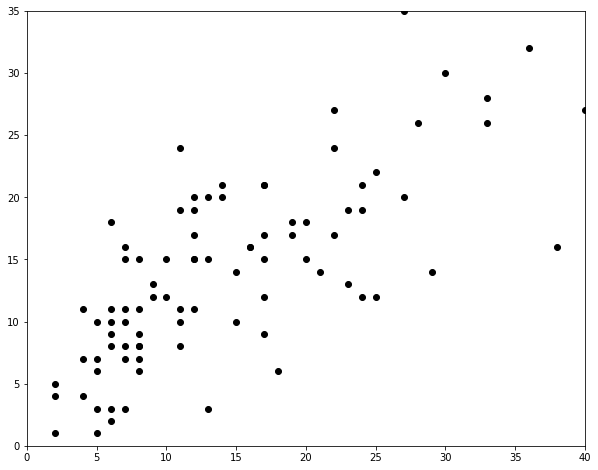

In [560]:
plt.scatter(encrypted["out_degree"], encrypted["in_degree"], c="black")

plt.xlim(0, encrypted["out_degree"].max())
plt.ylim(0, encrypted["in_degree"].max())

In [546]:
x_out = np.linspace(0, encrypted["out_degree"].max(), 10)
x_in = np.linspace(0, encrypted["in_degree"].max(), 10)

Text(0.5, 1.0, 'Fokszámeloszlás a kapcsolati hálózatban')

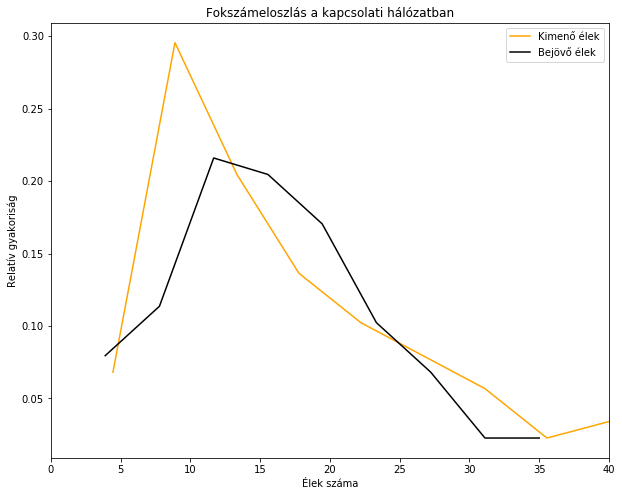

In [561]:
plt.plot(
    x_out[1:],
    pd.cut(encrypted["out_degree"], bins=x_out)
    .value_counts(normalize=True)
    .sort_index(),
    c="orange",
    label="Kimenő élek"
)
plt.plot(
    x_in[1:],
    pd.cut(encrypted["in_degree"], bins=x_in)
    .value_counts(normalize=True)
    .sort_index(),
    c="black",
    label="Bejövő élek"
)

plt.xlim(0, max(encrypted["out_degree"].max(), (encrypted["in_degree"].max())))
plt.xlabel("Élek száma")
plt.ylabel("Relatív gyakoriság")
plt.legend()
plt.title("Fokszámeloszlás a kapcsolati hálózatban")

### visualization

In [500]:
pyvis_network = Network(
    notebook=True,
    directed=True,
    height="750px",
    width="100%",
    bgcolor="white",
)

In [501]:
for node in G.nodes():
    mean_deg = (G.in_degree(node) + G.out_degree(node)) / 2
    pyvis_network.add_node(
        str(node),
        mass=mean_deg * 5,
        size=(mean_deg + 1) * 2,
        color="#222222",
    )

In [502]:
for i, row in edges_df.iterrows():
    pyvis_network.add_edge(
        str(row["from"]), str(row["to"]), color=topics[row["Domináns téma"]], width=5
    )

[hex color codes](https://www.color-hex.com/color-palettes/)

In [570]:
os.makedirs("docs", exist_ok=True)

In [571]:
pyvis_network.show('docs/index.html')